In [1]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import os 
from matplotlib.patches import Polygon
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}

## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible', 'MSM',
       'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION', 'Midwest', 'Northeast',
       'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC',
       'DELTA_REGION', 'DELTA_CLINIC'],
      dtype='object')


In [36]:
################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]
### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# logistic regression 
space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}
# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_rf,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models2 = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


for year in test_years: 
     #get dataset
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
     ## Get hyperparameters, new features, and auROC for each model type
    for model_type in range(len(model_types)):
        ## Hyperparameter tuning round 1
        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
        best_hyperparameters1 = get_best_hyperparameters(unfitted_models[model_type], cv, space[model_type], X_train, y_train)
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'], random_state = 10)

        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)

        elif model_type == 2:
            model = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=10, learning_rate =best_hyperparameters1['learning_rate'])

        model_fit = model.fit(X_train, y_train)

        ## Feature engineering
        important_features = get_best_features(feature_names, model_fit, X_test, y_test)
        best_features_by_year[model_type].__setitem__(year, important_features) 
        imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, model_fit, X_test, y_test) #want it to be the correct block for each model

        # Get new tets/train data and redo hyperparameters
        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features,years_train = years_train, model_type = model_type)
        best_hyperparameters2 = get_best_hyperparameters(model, cv, space[model_type], X_train, y_train)

        best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 

        ##
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])
        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)
        elif model_type == 2:
            model = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 3000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=10, learning_rate =best_hyperparameters2['learning_rate'])

        model_fit= model.fit(X_train, y_train)
        y_predict_test = model_fit.predict(X_test)
        y_predict_proba_test = model_fit.predict_proba(X_test)

        ROC= metrics.roc_auc_score(y_test, y_predict_test)
        ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l1', 'l2'], 'C': array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01])}


KeyboardInterrupt: 

Master cell doesn't work - use individual models below


In [2]:
################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=20,random_state=1) ## 10-fold cross validations
# logistic regression 
space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}
# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_rf,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models2 = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]



In [79]:
print(best_features_by_year[1])

{2005: ['MSW', 'MSM', 'Oth/Unk/Missing'], 2006: ['MSW', 'MSM', 'Southeast', 'Northeast', 'PREV_REGION', 'Oth/Unk/Missing'], 2007: ['MSW', 'MSM', 'Oth/Unk/Missing'], 2008: ['MSW', 'MSM', 'Northeast', 'PREV_CLINIC', 'Oth/Unk/Missing', 'Southeast'], 2009: ['Oth/Unk/Missing'], 2010: ['DELTA_CLINIC', 'DELTA_REGION']}


In [ ]:
## Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)

i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
     
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, model_fit, X_test, y_test) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

In [11]:
## Just RF
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

space = dict()
space['n_estimators'] = np.arange(100, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 25, 1)
space['min_samples_leaf'] = np.arange(1, 25, 1)
i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)
    
     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, model_fit, X_test, y_test) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)

    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2005
Oversample
Oversample
2006
Oversample
Oversample
2007
Oversample
Oversample
2008
Oversample
Oversample
2009
Oversample
Oversample
2010
Oversample
Oversample


In [3]:
## Just NN
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=337, learning_rate = 'adaptive' )

space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 1000)
space['learning_rate'] = ['constant', 'adaptive']

space['hidden_layer_sizes'] = [(8,), (9,), (10,), (11,), (12,), (13,), (14,)]
space['solver'] = ['lbfgs', 'sgd', 'adam']

i = 0
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    model_nn = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])
    
     
    ## fit model w/hyperparameters 
    model_fit = model_nn.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, model_fit, X_test, y_test) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_nn = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])

    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2005
Oversample
Oversample
2006
Oversample
Oversample
2007
Oversample
Oversample
2008
Oversample
Oversample
2009
Oversample
Oversample
2010
Oversample
Oversample


Oversample


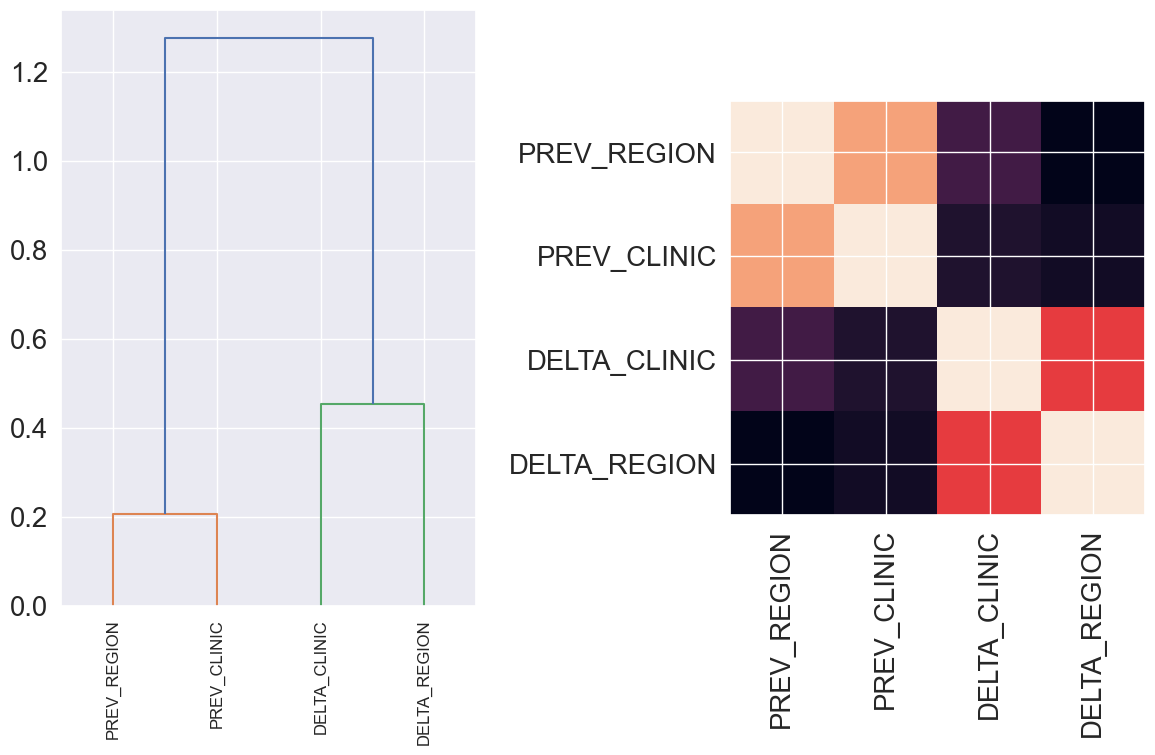

In [404]:
### Check collinearity of features 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

year = 2007
model_type = 1
test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
X_train = X_train[["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']]
X_test = X_test[["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']]
feature_names_region = ["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=feature_names_region, ax = ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

[Text(0, 0.5, 'Southeast'),
 Text(0, 1.5, 'Midwest'),
 Text(0, 2.5, 'DELTA_CLINIC'),
 Text(0, 3.5, 'West'),
 Text(0, 4.5, 'PREV_CLINIC'),
 Text(0, 5.5, 'PREV_REGION'),
 Text(0, 6.5, 'DELTA_REGION'),
 Text(0, 7.5, 'MSMW'),
 Text(0, 8.5, 'MSM'),
 Text(0, 9.5, 'MSW'),
 Text(0, 10.5, 'Oth/Unk/Missing'),
 Text(0, 11.5, 'Northeast'),
 Text(0, 12.5, 'Southwest')]

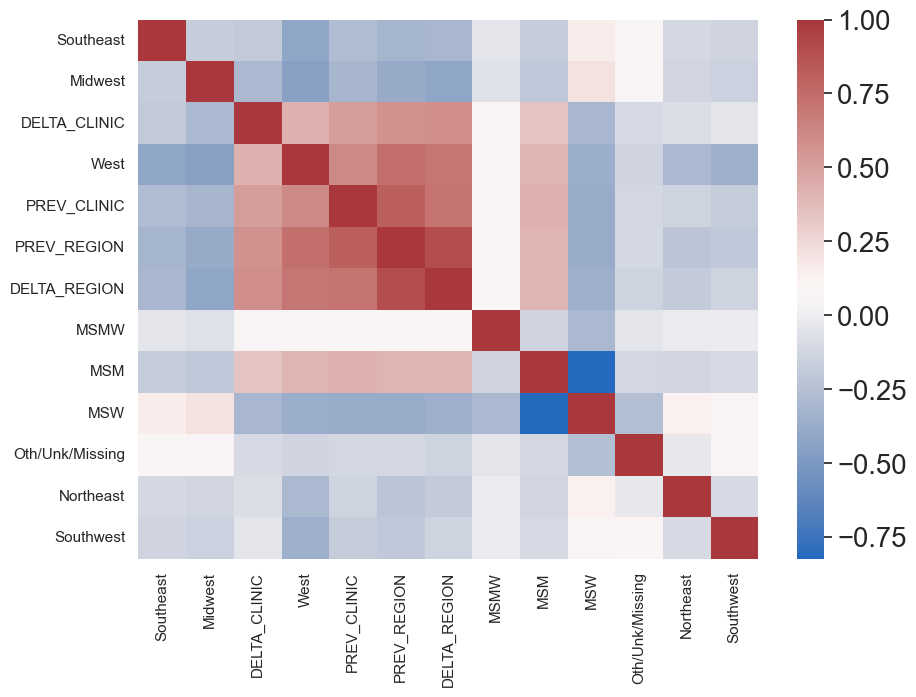

In [277]:
fig, ax = plt.subplots(figsize=(10,7))

sb.heatmap(corr[dendro["leaves"], :][:, dendro["leaves"]],cmap='vlag')
ax.set_xticklabels(dendro["ivl"], size = 11, rotation="vertical")
ax.set_yticklabels(dendro["ivl"], size = 11, rotation="horizontal")

In [308]:
## Get correlated features 
from collections import defaultdict

def get_correlated_features(X_train, distance_threshold, geographic_trend_features): 
    corr = spearmanr(X_train).correlation
    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    #   We convert the correlation matrix to a distance matrix before performing hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    cluster_ids = hierarchy.fcluster(dist_linkage, distance_threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    important_features = []
    for feature in selected_features:
        important_features.append(geographic_trend_features[feature])
    return(important_features)







In [425]:
year = 2007
test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
X_train = X_train[["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']]
X_test = X_test[["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']]
geographic_trend_features = ["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']
other_features = ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest']
corr = spearmanr(X_train).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)

dist_linkage = hierarchy.ward(squareform(distance_matrix))

cluster_ids = hierarchy.fcluster(dist_linkage, 0, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
#print(selected_features)
important_features = []
for feature in selected_features:
    important_features.append(geographic_trend_features[feature])
print(important_features)
important_features = important_features + other_features
test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)

model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
model_fit = model_rf.fit(X_train, y_train)

important_features_model = get_best_features(important_features, model_fit, X_test, y_test)
imporances =  get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model


Oversample
['DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'PREV_CLINIC']
Oversample


In [426]:
print(imporances)


[-0.013954068896655021, -0.002434681311366286, 0.0010567482110168057, -0.0003677816608420592, 0.0019337660176402072, -0.02121318022965551, -0.003942419703777666, -0.007638542186719923, -0.008691962056914634, -0.014358462306540191, 0.006155766350474284, 0.001293060409385921, -0.012960559161258111]


In [354]:

def get_feature_effects(all_features, important_features, model_fit, X_test, y_test):
    PI = permutation_importance(
        model_fit, X_test, y_test, n_repeats=100, random_state=42
    )
    feature_importances = []
    for feature in all_features:
        if feature in important_features:
            feature_importances.append(PI.importances_mean[important_features.index(feature)])
        else:
            feature_importances.append(0)
    return feature_importances

def get_best_features(feature_names, model_fit, X_test, y_test):
    PI = permutation_importance(
        model_fit, X_test, y_test, n_repeats=100, random_state=42
    )
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - PI.importances_std[q] >0:
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    return important_features


In [457]:
######### Hyperparameters and features for NN with collinearity adjustment 
geographic_trend_features = ["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']
other_features = ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest']

## Just NN
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=337, learning_rate = 'adaptive' )

space = dict()
space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 1000)
space['learning_rate'] = ['constant', 'adaptive']

space['hidden_layer_sizes'] = [(8,), (9,), (10,), (11,), (12,), (13,), (14,)]
space['solver'] = ['lbfgs', 'sgd', 'adam']
imporances_all_models_nn ={}
test_years = [2007,2008,2009]
i = 2
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    X_train = X_train[geographic_trend_features]
    feature_names_collinear = get_correlated_features(X_train, 0, geographic_trend_features)
    non_collinear_features = feature_names_collinear + other_features
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = non_collinear_features, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    model_nn = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=337, learning_rate =best_hyperparameters1['learning_rate'])
    
     
    ## fit model w/hyperparameters 
    model_fit = model_nn.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(non_collinear_features, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models_nn[year] =  get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model

    #imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, model_fit, X_test, y_test) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_nn = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])

    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2007
Oversample
Oversample
Oversample
2008
Oversample
Oversample
Oversample
2009
Oversample
Oversample
Oversample


In [458]:

print(best_hyperparameters_by_year[2])

print(best_features_by_year[2])

print(ROC_by_year[2])

{2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (12,), 'alpha': 0.17629753752872057, 'activation': 'tanh'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}
{2005: ['MSM', 'MSW', 'DELTA_CLINIC', 'Southeast', 'Southwest', 'DELTA_REGION', 'MSMW', 'Oth/Unk/Missing'], 2006: ['DELTA_CLINIC', 'MSW', 'MSM', 'PREV_CLINIC', 'PREV_REGION', 'DELTA_R

In [355]:
## LR WITH COLLINEARITY ADJUSTMENT 
geographic_trend_features = ["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']
other_features = ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest']

model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    X_train = X_train[geographic_trend_features]
    feature_names_collinear = get_correlated_features(X_train, 0.2,geographic_trend_features)
    print(feature_names_collinear)
    non_collinear_features = feature_names_collinear + other_features
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = non_collinear_features, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
     
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(non_collinear_features, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model
    # get new test/train data and hyperparameter tuning round 2 

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2005
['DELTA_CLINIC', 'DELTA_REGION', 'PREV_CLINIC']


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

2006
['DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'PREV_CLINIC']


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

2007
['DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION']


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

2008
['DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION']


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_ini

2009
['DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'PREV_CLINIC']


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

2010
['DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'PREV_CLINIC']


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

In [451]:

def get_feature_effects(all_features, important_features, model_fit, X_test, y_test):
    PI = permutation_importance(
        model_fit, X_test, y_test, n_repeats=10, random_state=42
    )
    feature_importances = []
    for feature in all_features:
        if feature in important_features:
            feature_importances.append(PI.importances_mean[important_features.index(feature)])
        else:
            feature_importances.append(0)
    return feature_importances

def get_best_features(feature_names, model_fit, X_test, y_test):
    PI = permutation_importance(
        model_fit, X_test, y_test, n_repeats=10, random_state=42
    )
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - PI.importances_std[q] >0:
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    return important_features

In [453]:
## RF WITH COLLINEARITY ADJUSTMENT 
geographic_trend_features = ["DELTA_CLINIC", "DELTA_REGION", 'PREV_REGION', 'PREV_CLINIC']
other_features = ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest']

model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 100)

space = dict()
space['n_estimators'] = np.arange(100, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 25, 1)
space['min_samples_leaf'] = np.arange(1, 25, 1)
i = 0
test_years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    X_train = X_train[geographic_trend_features]
    feature_names_collinear = get_correlated_features(X_train, 0.4,geographic_trend_features)

    non_collinear_features = feature_names_collinear + other_features
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = non_collinear_features, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 100)
    
     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features = get_best_features(non_collinear_features, model_fit, X_test, y_test)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_test, y_test) #want it to be the correct block for each model
    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 100)

    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

2009
Oversample
Oversample
Oversample


In [456]:
important_features

['Northeast']

In [454]:
print(best_hyperparameters_by_year[0])
print(best_hyperparameters_by_year[1])
print(best_hyperparameters_by_year[2])

print(best_features_by_year[0])
print(best_features_by_year[1])
print(best_features_by_year[2])

print(ROC_by_year[0])
print(ROC_by_year[1])
print(ROC_by_year[2])

{2005: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2009: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}
{2005: {'n_estimators': 171, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': 89}, 2006: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2007: {'n_estimators': 189, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_depth': 185}, 2008: {'n_estimators': 171, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_depth': 89}, 2009: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2010: {'n_estimators': 175, 'min_samples_split': 14, 'min_samples_leaf': 21, 'max_depth': 197}}
{2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 

In [433]:
print(best_features_by_year[1])

{2005: ['Northeast', 'DELTA_CLINIC', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing', 'Southeast', 'Southwest', 'Midwest'], 2006: ['MSW', 'Southeast'], 2007: ['PREV_CLINIC', 'Northeast'], 2008: ['DELTA_CLINIC', 'MSW', 'MSM', 'DELTA_REGION', 'MSMW', 'Oth/Unk/Missing'], 2009: ['Northeast'], 2010: ['DELTA_CLINIC', 'PREV_REGION']}


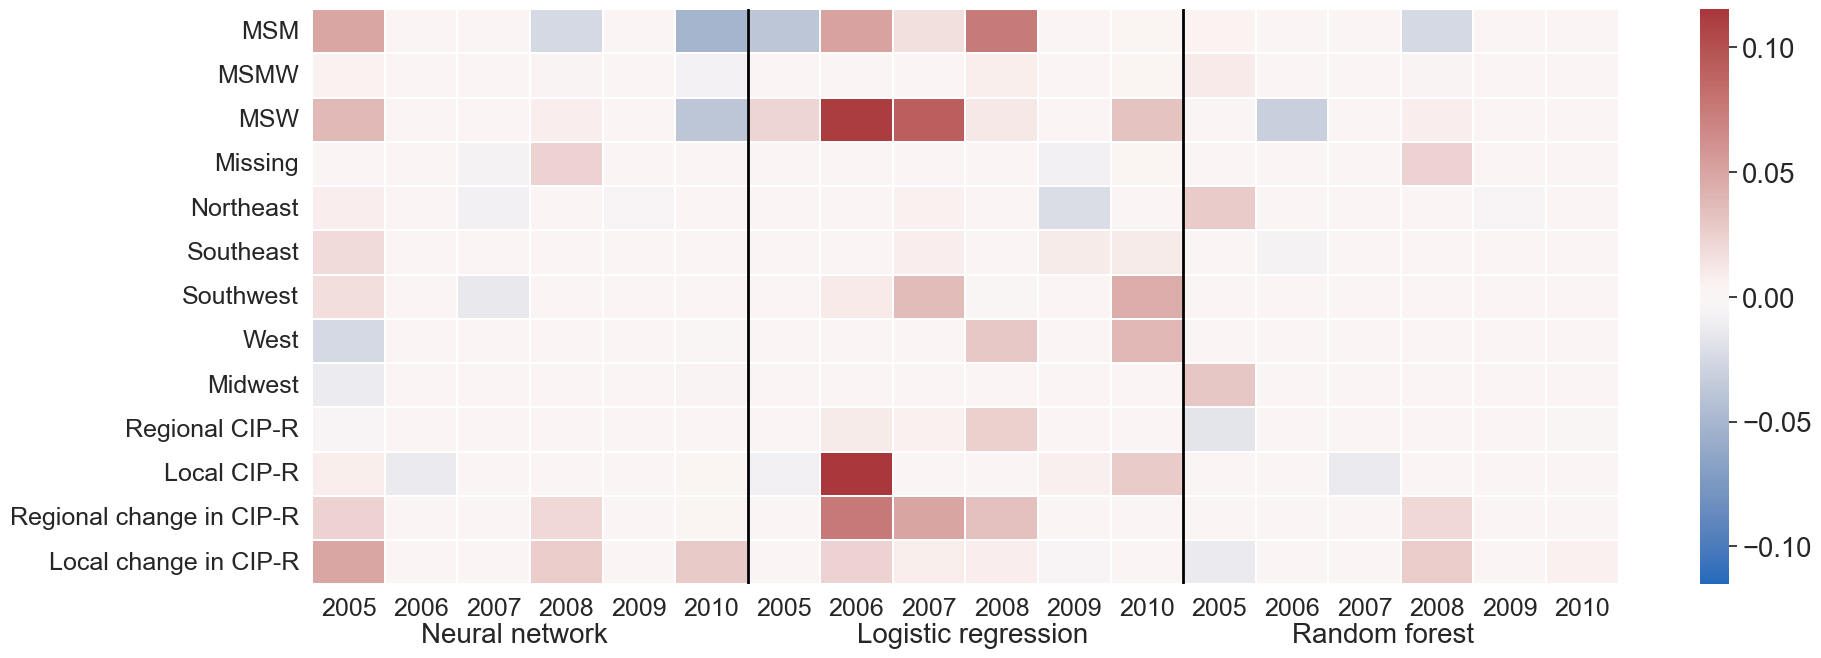

In [434]:
## Figure 1: Graph of important features

fig, ax = plt.subplots(figsize=(20,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*3
y_axis_labels =['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R']

ax.tick_params(axis='both', which='major', labelsize=18)

sb.heatmap(imporances_all_models,fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.max()).max(), vmax = abs(imporances_all_models.max()).max())
ax.text((ax.get_xlim()[1])/18 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Neural network", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 7.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 13.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/18 * 6, color = "black", linewidth = 2)
ax.axvline((ax.get_xlim()[1])/18 * 12, color = "black", linewidth = 2)

plt.tight_layout()

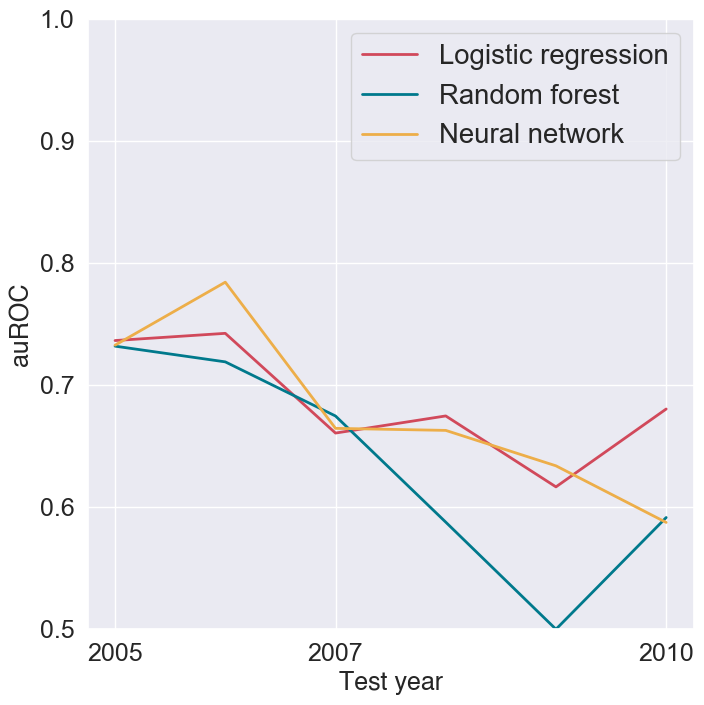

In [443]:
## Figure 2: auROC by model and year 
 
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks([2005, 2007, 2010])
axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Test year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend()
plt.tight_layout()


In [57]:
## Plot labes - needed for all subsequent graphs 
text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]
labels = ["A", "B", "C", "D", "E", "F" ]


Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


KeyboardInterrupt: 

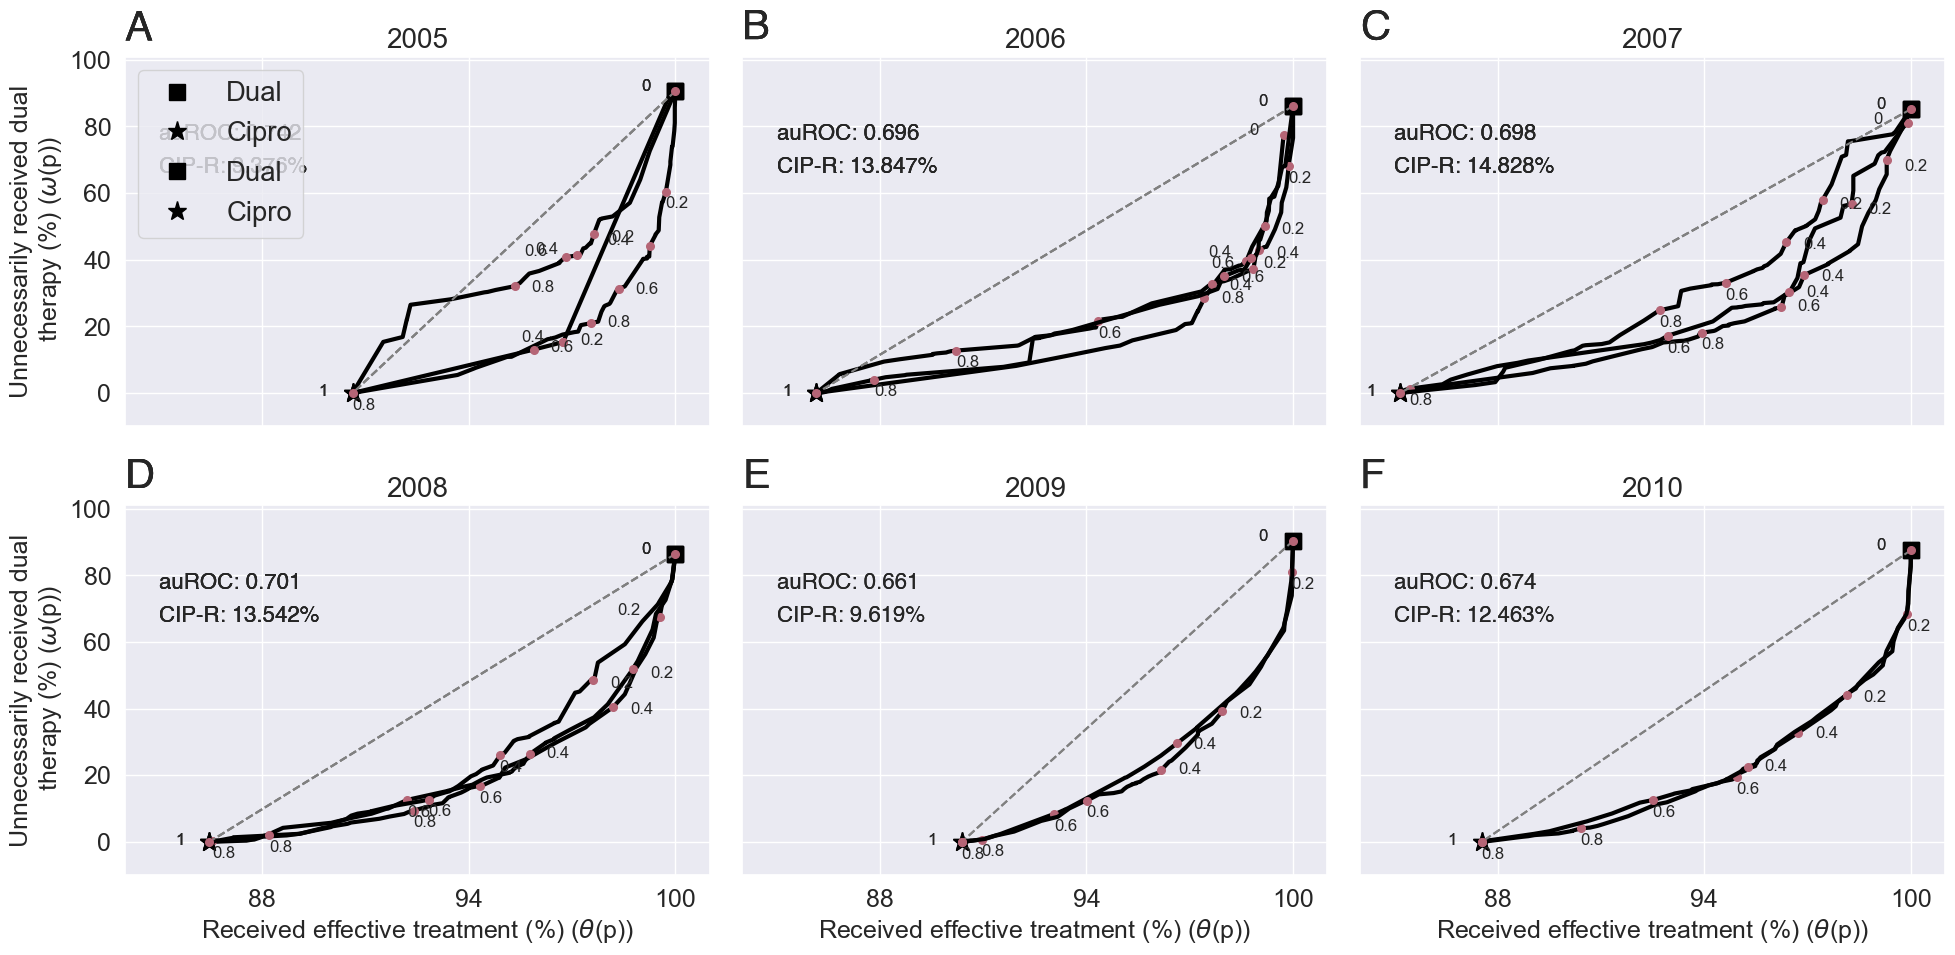

In [21]:
## Figure 3: proportion getting effective treatment and unnecessary dual therapy (+ S)

###### Effect of threshold on year-by-year for logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)


for model_type in range(len(model_types)):
    i = 0
    for year in years:
        years_train = np.array(range(year - 5, year))
        
        #Retrieve data (from previous loop)
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
        
        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

        else:
            model = MLPClassifier(solver = 'lbfgs', activation = best_hyperparameters_by_year[model_type][year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[model_type][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[model_type][year]['alpha'], random_state=10, learning_rate =best_hyperparameters_by_year[model_type][year]['learning_rate'])

        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
        
        ## Fit model
        model_fit = model.fit(X_train, y_train)
        y_predict_test = model_fit.predict(X_test)
        y_predict_proba = model_fit.predict_proba(X_test)
        
        ## Get effective treatment and unnecessary dual 
        sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

        #plot
        axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
        axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "Dual")
        axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
        axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
        axs[i].set_title(year,fontsize=20)  
        axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 25, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
        axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    
        x = 0
        for index in indices:
            axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
            if index == 100:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] - 1, text_for_graph[x], size = 12)
            elif index == 0:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index], text_for_graph[x], size = 12)
            elif (get_effective_threshold[index] > 95) & (get_effective_threshold[index] < 99.6):
                if abs(get_effective_threshold[index] - get_effective_threshold[index-20]) < 0.5:
                    if (incorrectly_get_X_threshold[index] - incorrectly_get_X_threshold[index-20] < 1):
                        axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*1.01, text_for_graph[x], size = 12)#, color = "blue")
                    else:
                        axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "green")
                else:
                    axs[i].text(get_effective_threshold[index]*1.005, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "red")
            
            else:
                axs[i].text(get_effective_threshold[index]- 0.01, incorrectly_get_X_threshold[index]-5, text_for_graph[x], size = 12)
            
            x = x+1
        i += 1

    plt.tight_layout()
    axs[0].legend()
    plotname = "Effective_vs_unnecessary_treatment" + model_types[model_type] + ".png"
    #plt.savefig("plotname", dpi = 600)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


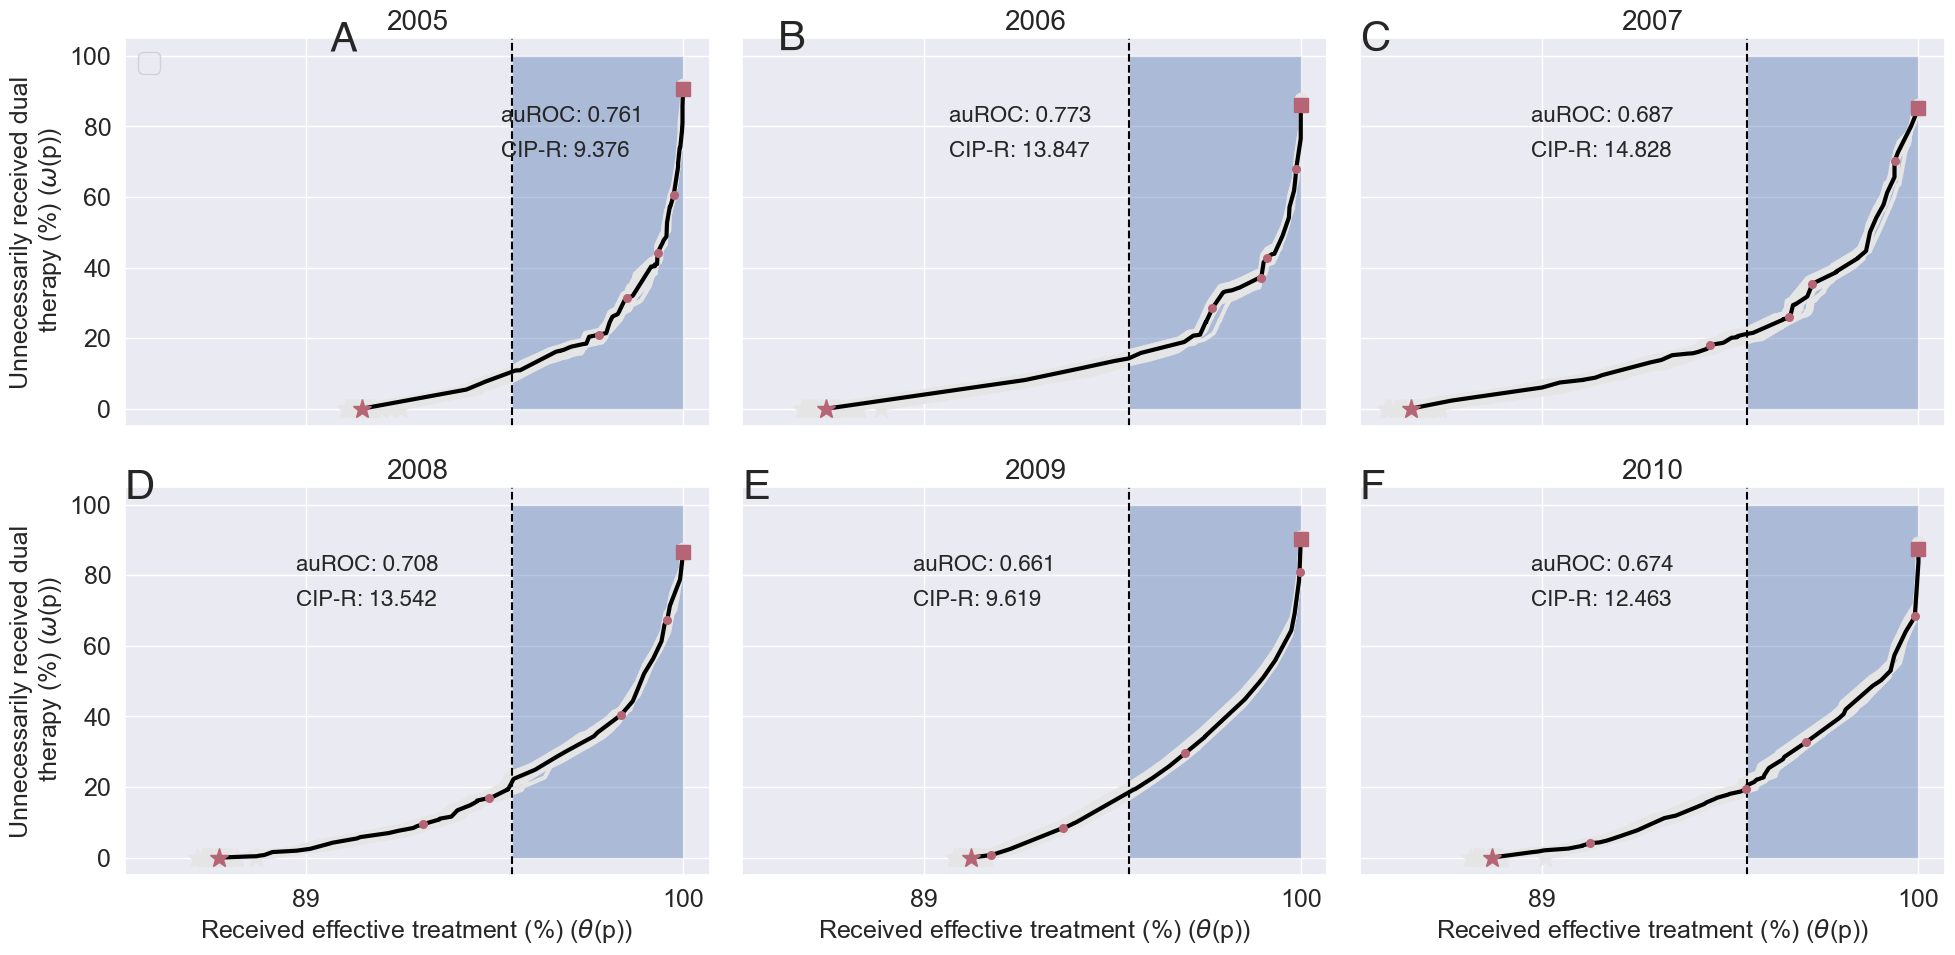

In [159]:
## Figure 4: LOOCV
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

### Leave one out validation for random forest
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)

model_types = [2]
axs = axs.ravel()
i = 0
for model_type in range(len(model_types)):
  for year in years: 
      years_train = np.array(range(year - 5, year))

      # First do for all clinics 

      CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
      CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
        
      #Retrieve data (from previous loop)
      if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
        
      elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

      else:
            model = MLPClassifier(solver = 'lbfgs', activation = best_hyperparameters_by_year[model_type][year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[model_type][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[model_type][year]['alpha'], random_state=10, learning_rate =best_hyperparameters_by_year[model_type][year]['learning_rate'])

      test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
        
      ## Fit aggregate model 
      model_fit = model.fit(X_train, y_train)
      y_predict_test = model_fit.predict(X_test)
      y_predict_proba = model_fit.predict_proba(X_test)
  
      ## Get effective treatment and unnecessary dual for aggregate model
      senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


      clinics = CIP_data_testing_years["CLINIC"].unique()
      for clinic in clinics: 
          test_data, train_data, X_train, y_train, X_test, y_test, cipro_R =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop.loc[CIP_data_no_drop['CLINIC'] != clinic], year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)


          if cipro_R > 0: 
            try:

                model_fit = model.fit(X_train, y_train)
                y_predict_test = model_fit.predict(X_test)
                y_predict_proba = model_fit.predict_proba(X_test)
                senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

                axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
                axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
                axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
    

            
            except ValueError: #sometimes it's a very small number of CIPR in sample so need to change sampling strategy
              try:
                #get data
                oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)
                X_train, y_train = oversample.fit_resample(X_train,y_train)
                #X_test, y_test = oversample.fit_resample(X_test,y_test)
                #fit  
                model_fit_train = model_rf.fit(X_train, y_train)
                y_predict_test = model_fit_train.predict(X_test)
                y_predict_proba = model_fit_train.predict_proba(X_test)
                senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

                axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
                axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
                axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")

              except ValueError:
                print('x')
                pass


      axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3) #plot for aggregate model
      axs[i].plot(100, 100 - cipro_R_prev*100, marker='s', ls='none', ms=10, color = "#b56576")
      axs[i].plot((100-cipro_R_prev*100), 0, marker='*', ls='none', ms=14, color = "#b56576")
      axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
      axs[i].axvline(x = 95, color = 'black', linestyle="--")

      axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 15, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
      axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 25, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
      for index in indices:
          axs[i].plot(get_effective_threshold_all[index], incorrectly_get_X_threshold_all[index], marker='.', ls='none', ms=11, color = "#b56576")
      axs[i].set_title(year,fontsize=20)   

      i += 1   


  axs[0].add_patch(polygon_important0)
  axs[1].add_patch(polygon_important1)
  axs[2].add_patch(polygon_important2)
  axs[3].add_patch(polygon_important3)
  axs[4].add_patch(polygon_important4)
  axs[5].add_patch(polygon_important5)
  plt.tight_layout()
  axs[0].legend()
  #plotname = "LOOCV_effective_vs_unnecessary_treatment" + model_types[model_type] + ".png"
  #plt.savefig("plotname", dpi = 600)


In [ ]:
## SI: sensivitity and specificity 

###### Effect of threshold on year-by-year for logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel('Percentage (%)')
axs[1,0].set_ylabel('Percentage (%)')
axs[1,0].set_xlabel('Threshold (p)')
axs[1,1].set_xlabel('Threshold (p)')
axs[1,2].set_xlabel('Threshold (p)')

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)

i = 0

for model_type in range(len(model_types)):
    for year in years:
        years_train = np.array(range(year - 5, year))
        
        #Retrieve data (from previous loop)
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
        
        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

        else:
            model = MLPClassifier(solver = 'lbfgs', activation = best_hyperparameters_by_year[model_type][year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[model_type][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[model_type][year]['alpha'], random_state=10, learning_rate =best_hyperparameters_by_year[model_type][year]['learning_rate'])

        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
        
        ## Fit model
        model_fit = model.fit(X_train, y_train)
        y_predict_test = model_fit.predict(X_test)
        y_predict_proba = model_fit.predict_proba(X_test)
        
        ## Get effective treatment and unnecessary dual 
        sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

        #plot
        axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity ($\alpha$(p))", linewidth = 2)
        axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity ($\beta$(p))", linewidth = 2)
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
        i += 1

    plt.tight_layout()
    axs[0].legend()
    plotname = "Sensitivity_specificity" + model_types[model_type] + ".png"
    #plt.savefig("plotname", dpi = 600)


In [64]:
print(best_features_by_year)

[{2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSW', 'Southwest', 'Northeast', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'Northeast', 'PREV_REGION', 'MSW', 'MSM', 'Southwest', 'Southeast', 'Oth/Unk/Missing', 'MSMW'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing', 'Northeast', 'Southwest'], 2008: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'Northeast', 'Southeast', 'MSMW', 'Oth/Unk/Missing', 'Southwest'], 2009: ['PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC'], 2010: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'Northeast', 'MSMW', 'DELTA_REGION', 'West', 'Southeast']}, {2005: [], 2006: ['MSW', 'MSM'], 2007: ['MSW', 'PREV_CLINIC', 'MSM', 'Oth/Unk/Missing', 'Northeast'], 2008: ['MSW', 'MSM', 'Northeast', 'Oth/Unk/Missing'], 2009: ['Oth/Unk/Missing'], 2010: ['DELTA_CLINIC', 'DELTA_REGION', 'Midwest']}, {2005: ['DELTA_CLINIC', 'MSW', 'MSM', 'PREV_CLINIC', 'DELTA_REGION', 'Southeast', 'West

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


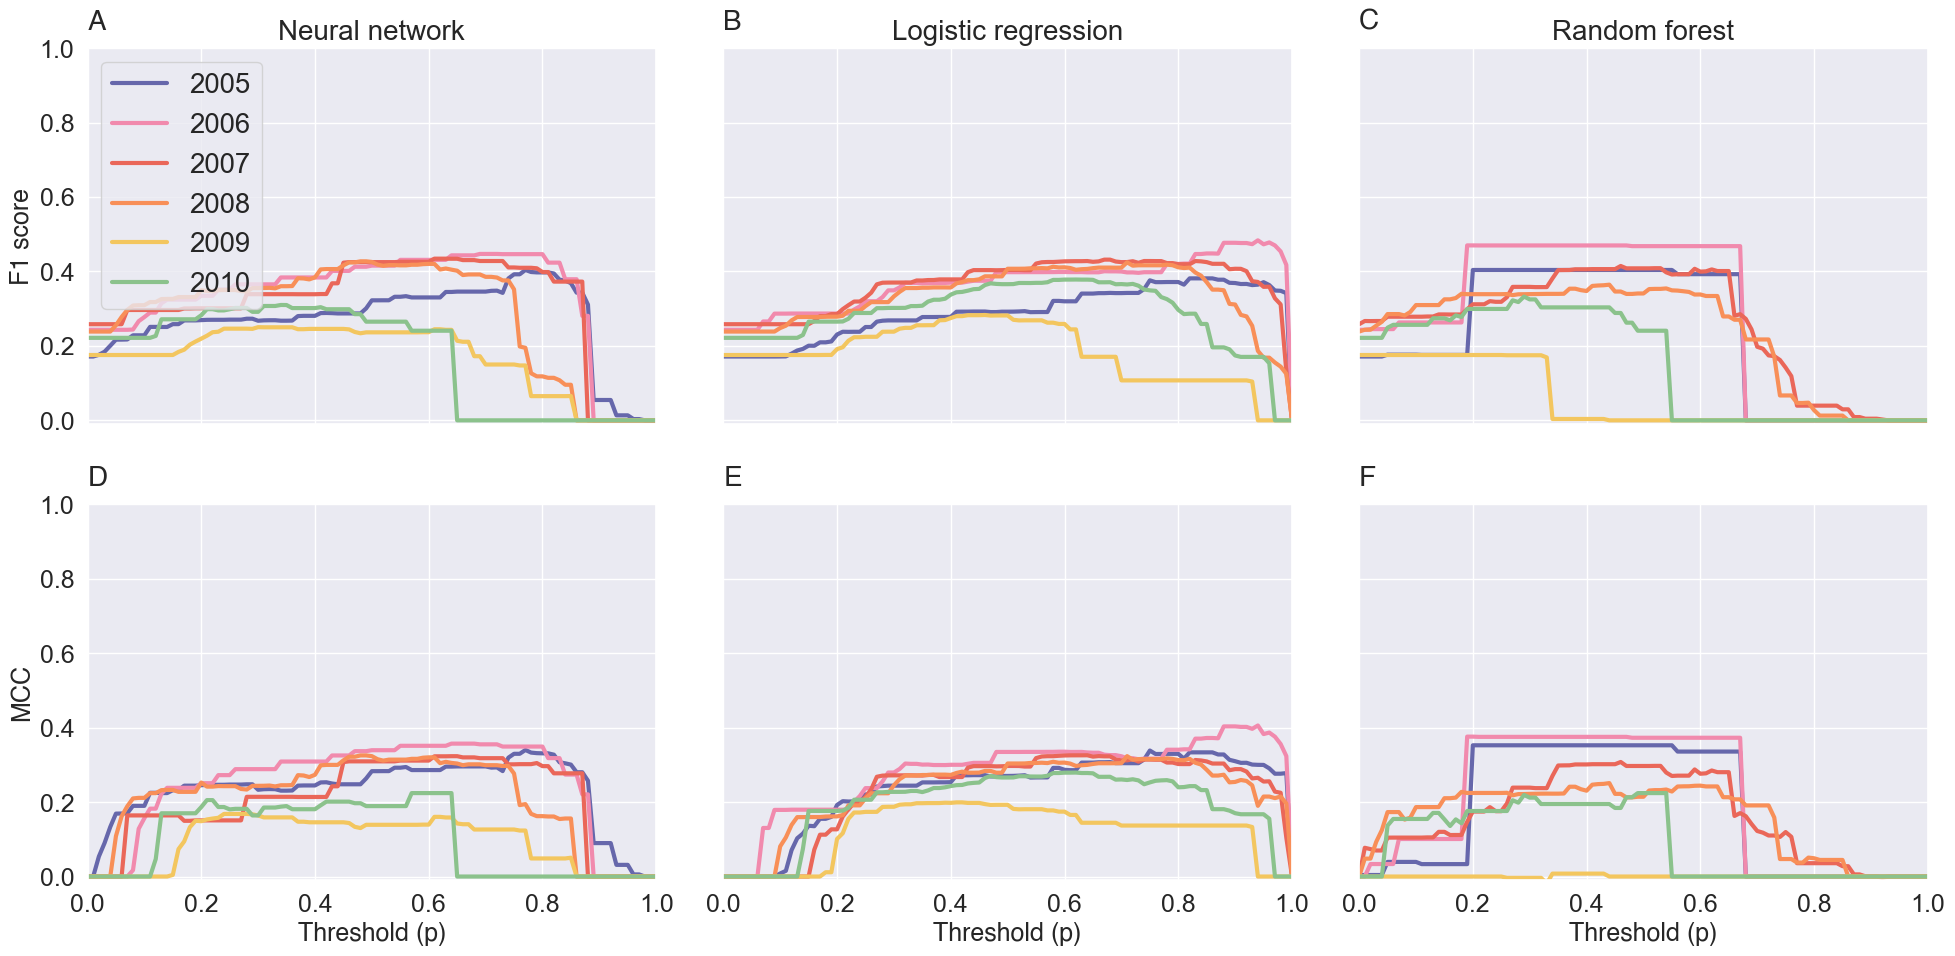

In [75]:
## SI: model performance
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
colors = ["#6667ab", "#f18aad", "#ea6759", "#f88f58", "#f3c65f", "#8bc28c"]

axs[0,0].set_ylabel('F1 score', fontsize = 18, **hfont)
axs[1,0].set_ylabel('MCC', fontsize = 18, **hfont)
axs[1,0].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,1].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,2].set_xlabel("Threshold (p)", fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_ylim([0-.010,1])
axs[0,0].set_xlim([0, 1])

axs = axs.ravel()


for i in range(len(model_types)): #i is stand-in for "model type"
    x = 0
    
    if i == 0:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_nn = MLPClassifier(solver = best_hyperparameters_by_year[2][year]['solver'], activation = best_hyperparameters_by_year[2][year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[2][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[2][year]['alpha'], random_state=10, learning_rate = 'adaptive' )
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[2][year], years_train = years_train, model_type = 2)

            ## fit model
            model_fit = model_nn.fit(X_train, y_train)
            y_predict_test = model_fit.predict(X_test)
            y_predict_proba = model_fit.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Neural network",fontsize=20)
        axs[i].legend()


    if i == 1:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[0][year]['solver'], C = best_hyperparameters_by_year[0][year]['C'], penalty = best_hyperparameters_by_year[0][year]['penalty'])
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[0][year], years_train = years_train, model_type = 0)

            ## fit model
            model_fit_train = model_lr.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
   
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Logistic regression",fontsize=20)

    
    if i == 2:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[1][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[1][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[1][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[1][year]['max_depth'], random_state = 10)
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[1][year], years_train = years_train, model_type = 1)
            
            ## fit model
            model_fit_train = model_rf.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)

            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Random forest",fontsize=20)

plt.tight_layout()
#plt.savefig('F1_MCC_score_all_years_all_models.png', dpi = 600)
